# Installation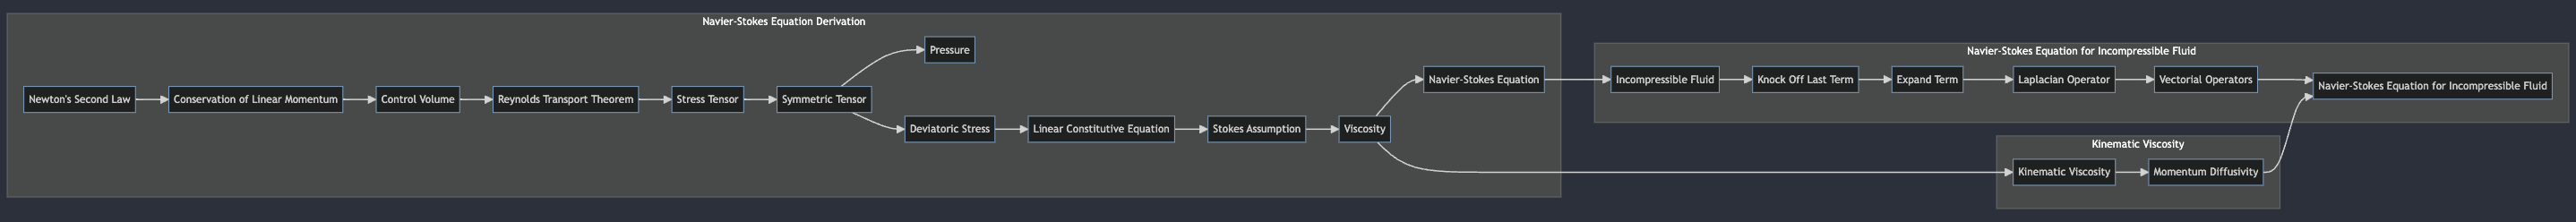

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q cassandra-driver
!pip install -q cassio>=0.1.1
!pip install -q gradientai --upgrade
!pip install -q llama-index
!pip install -q pypdf
!pip install -q tiktoken==0.4.0
!pip install -U -q openai-whisper
!pip install ffmpeg

# Import OS & JSON Modules

In [2]:
import os
import json
from google.colab import userdata

#os.environ['GRADIENT_ACCESS_TOKEN'] = userdata.get('grad_token')
#os.environ['GRADIENT_WORKSPACE_ID'] =  userdata.get('grad_id')

# Import Cassandra & llama Index

In [5]:
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster
from llama_index import ServiceContext
from llama_index import set_global_service_context
from llama_index import VectorStoreIndex, SimpleDirectoryReader, StorageContext
from llama_index.embeddings import GradientEmbedding
from llama_index.llms import GradientBaseModelLLM
from llama_index.vector_stores import CassandraVectorStore

In [6]:

import cassandra
print (cassandra.__version__)

3.29.0


# Connect to the VectorDB

In [7]:
# This secure connect bundle is autogenerated when you donwload your SCB,
# if yours is different update the file name below
cloud_config= {
  'secure_connect_bundle': '/content/drive/MyDrive/multimodal_stuff/secure-connect-mydb.zip'
}

# This token json file is autogenerated when you donwload your token,
# if yours is different update the file name below
with open("/content/drive/MyDrive/multimodal_stuff/pranavsridhar05@gmail.com-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(135926321712000) 1e3c4fe4-7e14-49d3-aaf9-b16eacd6ed06-us-east-1.db.astra.datastax.com:29042:127ba7ec-ba98-4ed8-8857-66ac4222d9aa> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


4.0.11-6333c4449215


# Define the Gradient's Model Adapter for LLAMA-2

In [ ]:
llm = GradientBaseModelLLM(
    base_model_slug="llama2-7b-chat",
    max_tokens=400,
)

# Configure Gradient embeddings

In [10]:
embed_model = GradientEmbedding(
    gradient_access_token = os.environ["GRADIENT_ACCESS_TOKEN"],
    gradient_workspace_id = os.environ["GRADIENT_WORKSPACE_ID"],
    gradient_model_slug="bge-large",
)

In [11]:
from llama_index.llms import Gemini

In [12]:
gemini_pro =  Gemini(api_key=userdata.get('gemini_key'))

In [14]:
service_context = ServiceContext.from_defaults(
    llm = Gemini(api_key=userdata.get('gemini_key')),
    embed_model = embed_model,
    chunk_size=256,
)

set_global_service_context(service_context)

# Load the PDFs

In [16]:
documents = SimpleDirectoryReader("/content/Documents").load_data()
print(f"Loaded {len(documents)} document(s).")

Loaded 139 document(s).


# Setup and Query Index

In [17]:
index = VectorStoreIndex.from_documents(documents,
                                        service_context=service_context)
query_engine = index.as_query_engine()

## Transcript

In [18]:
!pip install pytube -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00


In [19]:
# importing packages
from pytube import YouTube
import os

# url input from user
yt = YouTube("https://www.youtube.com/watch?v=Y3lcc5rCJ8E")

# extract only audio
video = yt.streams.filter(only_audio=True).first()

# download the file
out_file = video.download()

# save the file
base, ext = os.path.splitext(out_file)
new_file = base + '.mp3'
os.rename(out_file, new_file)

# result of success
print(yt.title + " has been successfully downloaded.")

Lecture 09 has been successfully downloaded.


In [20]:
import whisper
model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 94.8MiB/s]


In [21]:
result = model.transcribe(new_file)
print(result["text"])

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Welcome to the session on Navistokes equation as part of the NPTEL MOOC on Transport Phenomenal and Materials. In this session we are going to derive the Navistokes equation starting from the Newton's second law of conservation of linear momentum. So, this session may look little tedious. However, I advise that you pause at appropriate locations, do some of the algebra yourself and then get back because it could be quite tedious if you are not familiar with the subscript notation, the tensor operations and the material derivative concept etcetera. So, all the things that we have done till now will all be converging into this particular derivation. So, do pay attention what is coming at what stage go back and refresh those concepts necessary. So, the concept map for the derivation of Navistokes equation is given here. The starting point for the Navistokes equation is nothing but the Newton's second law the conservation of linear momentum and we see that it basically is talking about th

In [22]:
transcript = result['text']

In [23]:
n_keywords = 10

In [24]:
response = gemini_pro.complete(f"Given the text transcript of a lecture, write the topic keywords involved in the lecture.\n {transcript}, Few things to be noted: Be very specific about the keyword and dont generalize on the whole topic, Give a maximum of{n_keywords} keywords")

In [32]:
print(response.text)

- Navier-Stokes equation
- Newton's second law
- Conservation of linear momentum
- Control volume
- Reynolds transport theorem
- Stress tensor
- Symmetric tensor
- Pressure
- Deviatoric stress
- Newtonian fluid


In [ ]:
p="Given the keywords from the lecture, retrieve relevant text from the document about these topics. You are to retrieve information and the theory behind the context given"+ f"Keywords: {response}"
response2 = query_engine.query(p)
print(response2)

In [34]:
big_small = "Elaborate" # Elaborate or compact or moderate size

In [37]:
response3 = gemini_pro.complete(f"Given the text transcript of a lecture and the required context from the text, write notes for the lecture. Include relvant formulas and mathematical relations from the given transcript and context. The notes must be {big_small} \n Transcript: {transcript}, Keywords: {response} and the Context={response2}")

In [38]:
print(response3)

**Navier-Stokes equation:**

The Navier-Stokes equation is a set of partial differential equations that describe the motion of viscous fluids. It is named after Claude-Louis Navier and George Gabriel Stokes, who independently derived the equations in the 19th century.

**Newton's second law:**

Newton's second law states that the acceleration of an object is directly proportional to the net force acting on the object, and inversely proportional to the mass of the object.

**Conservation of linear momentum:**

The conservation of linear momentum states that the total linear momentum of a closed system remains constant, provided that no external forces act on the system.

**Control volume:**

A control volume is a region of space through which fluid flows. The Navier-Stokes equation is applied to a control volume to determine the velocity and pressure of the fluid at each point within the control volume.

**Reynolds transport theorem:**

The Reynolds transport theorem is a mathematical t

In [39]:
response4 = gemini_pro.complete(f"Given the text transcript of a lecture and the required context from the text, write code for a mindmap on Mermaid for the lecture. Include relvant formulas and mathematical relations from the given transcript and context. The notes must be {big_small} \n Transcript: {transcript}, Keywords: {response} and the Context={response2}")

In [41]:
print(response4)

```mermaid
graph LR
subgraph Navier-Stokes Equation Derivation
    A[Newton's Second Law] --> B[Conservation of Linear Momentum]
    B --> C[Control Volume]
    C --> D[Reynolds Transport Theorem]
    D --> E[Stress Tensor]
    E --> F[Symmetric Tensor]
    F --> G[Pressure]
    F --> H[Deviatoric Stress]
    H --> I[Linear Constitutive Equation]
    I --> J[Stokes Assumption]
    J --> K[Viscosity]
    K --> L[Navier-Stokes Equation]
end
subgraph Navier-Stokes Equation for Incompressible Fluid
    L --> M[Incompressible Fluid]
    M --> N[Knock Off Last Term]
    N --> O[Expand Term]
    O --> P[Laplacian Operator]
    P --> Q[Vectorial Operators]
    Q --> R[Navier-Stokes Equation for Incompressible Fluid]
end
subgraph Kinematic Viscosity
    K --> S[Kinematic Viscosity]
    S --> T[Momentum Diffusivity]
    T --> R
end
```


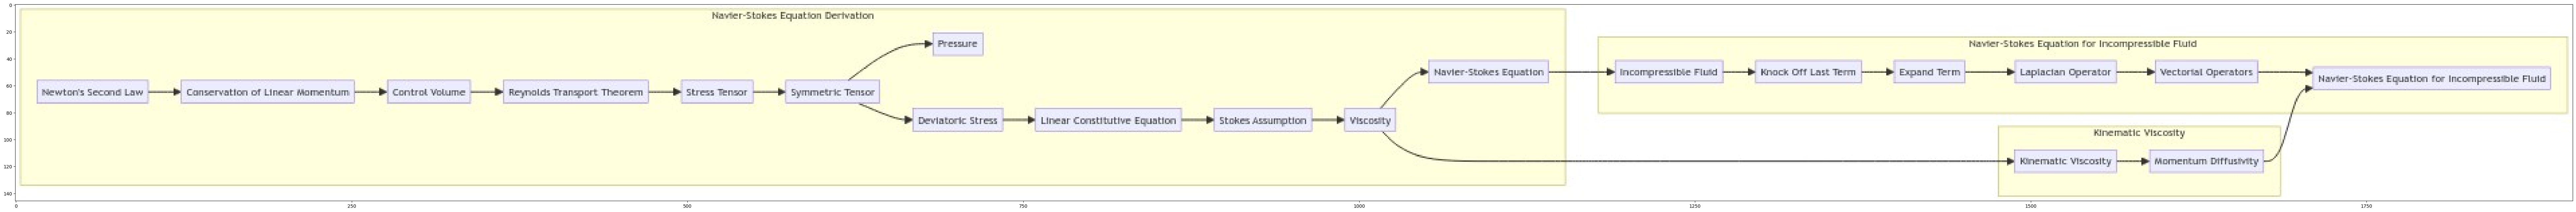

In [49]:
import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt

graph = response4.text.replace("```",'')
graph = graph.replace("mermaid","")

graphbytes = graph.encode("ascii")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")
img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
plt.figure(figsize=(100, 40))
plt.imshow(img)

**Lecture Notes: Navier-Stokes Equation and Fluid Mechanics**

**1. Navier-Stokes Equation:**

- The Navier-Stokes equation is a set of partial differential equations that describe the motion of viscous fluids.
- It is derived from Newton's second law of motion and the conservation of mass.
- The general form of the Navier-Stokes equation in vector notation is:

```
ρ(∂u/∂t + u⋅∇u) = -∇p + μ∇²u + ρg
```

where:

- ρ is the fluid density
- u is the fluid velocity
- t is time
- p is the pressure
- μ is the dynamic viscosity
- g is the acceleration due to gravity

**2. Newton's Second Law:**

- Newton's second law states that the acceleration of an object is directly proportional to the net force acting on the object and inversely proportional to the mass of the object.
- In the context of fluid mechanics, Newton's second law is used to derive the Navier-Stokes equation.

**3. Control Volume:**

- A control volume is a fixed region of space through which fluid flows.
- The Reynolds transport theorem is used to derive the conservation of mass, momentum, and energy equations for a control volume.

**4. Reynolds Transport Theorem:**

- The Reynolds transport theorem is a mathematical theorem that relates the rate of change of a quantity within a control volume to the flux of that quantity through the control surface.
- It is used to derive the conservation of mass, momentum, and energy equations for a control volume.

**5. Stress Tensor:**

- The stress tensor is a mathematical object that describes the forces acting on a fluid element.
- It is a symmetric tensor, meaning that its transpose is equal to itself.

**6. Pressure:**

- Pressure is a scalar quantity that describes the force per unit area acting on a fluid element.
- It is a thermodynamic variable that is related to the temperature and density of the fluid.

**7. Deviatoric Stress:**

- The deviatoric stress is the part of the stress tensor that is traceless.
- It is a measure of the shear stress acting on a fluid element.

**8. Newtonian Fluid:**

- A Newtonian fluid is a fluid whose shear stress is linearly proportional to the shear rate.
- The viscosity of a Newtonian fluid is constant.

**9. Stokes Assumption:**

- The Stokes assumption is a simplification of the Navier-Stokes equation that is used for low-Reynolds-number flows.
- It assumes that the viscous term in the Navier-Stokes equation is negligible compared to the pressure term.

**10. Viscosity:**

- Viscosity is a measure of the resistance of a fluid to flow.
- It is a transport property that is related to the molecular structure of the fluid.

**11. Kinematic Viscosity:**

- Kinematic viscosity is the ratio of the dynamic viscosity to the fluid density.
- It is a measure of the momentum diffusivity of a fluid.
